In [1]:
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

/home/rraju2/anaconda3/envs/mixer_cifar10/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from types import SimpleNamespace
from collections import OrderedDict
from utils.dataloader import get_dataloaders
from utils.vision_transformer import vit_base, DINOHead
from torch.utils.data import Dataset
from PIL import Image

In [3]:
%matplotlib inline

In [4]:
args = SimpleNamespace()

In [5]:
args.dataset = 'c10'
args.model = 'mlp_mixer'
args.batch_size = 10
args.eval_batch_size = 10
args.num_workers = 4
args.seed = 0
args.epochs = 300
args.patch_size = 4
args.autoaugment = False
args.use_cuda = False
args.size = 224
args.split = 'regular'

In [6]:
train_dataloader, test_dataloader = get_dataloaders(args)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
img, label = next(iter(train_dataloader))

In [8]:
grid_img = torchvision.utils.make_grid(img, nrow=5).permute(1,2,0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


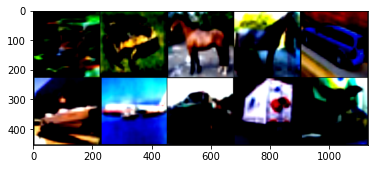

In [9]:
plt.imshow(grid_img)

In [10]:
model = vit_base(num_classes=100)

In [13]:
state_dict = torch.load('../artifacts/cifar100_ViT_B_dino.pth')

In [14]:
stripped_keys = OrderedDict()

In [15]:
for k, v in state_dict.items():
    stripped_keys[k.replace('module.','')] = v

In [16]:
model.load_state_dict(stripped_keys)

<All keys matched successfully>

In [17]:
new_heatmaps = model.get_last_selfattention(img)[:,:,0,1:]

In [18]:
w_featmap = int(np.sqrt(new_heatmaps.shape[-1]))
h_featmap = int(np.sqrt(new_heatmaps.shape[-1]))
scale = img.shape[2] // w_featmap

In [19]:
first_img = new_heatmaps[7,:].detach().cpu().numpy()

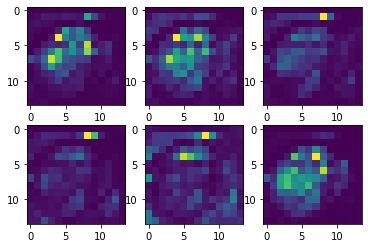

In [20]:
# display images
# plt.imshow(test_img)
# plt.axis('off')
fig, ax = plt.subplots(2,3)
ax[0][0].imshow(first_img[0].reshape(w_featmap,h_featmap))
ax[0][1].imshow(first_img[1].reshape(w_featmap,h_featmap))
ax[0][2].imshow(first_img[2].reshape(w_featmap,h_featmap))
ax[1][0].imshow(first_img[3].reshape(w_featmap,h_featmap))
ax[1][1].imshow(first_img[4].reshape(w_featmap,h_featmap))
ax[1][2].imshow(first_img[5].reshape(w_featmap,h_featmap))
# ax[1].imshow(img_B)

In [21]:
mean_heatmap = np.mean(first_img, 0)

In [22]:
test = torch.nn.functional.interpolate(torch.tensor(mean_heatmap.reshape(14,14)[None,None,:]), scale_factor=scale, mode="nearest")

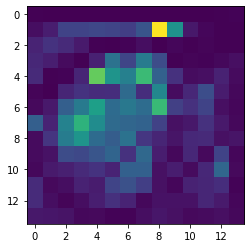

In [23]:
plt.imshow(mean_heatmap.reshape(14,14))

In [24]:
avg_attn_maps = torch.mean(new_heatmaps, dim=1)

In [25]:
drop_lambda = 0.3

In [26]:
val, idx = torch.sort(avg_attn_maps, dim=1)
threshold = torch.quantile(val, drop_lambda, dim=1)
th_attn = val >= threshold[:,None]

In [27]:
idx2 = torch.argsort(idx, dim=1)

In [28]:
for batch_idx in range(th_attn.shape[0]):
    th_attn[batch_idx] = th_attn[batch_idx][idx2[batch_idx]]

In [29]:
bin_mask = th_attn.reshape(-1, w_featmap, h_featmap).float()
mask = torch.nn.functional.interpolate(bin_mask.unsqueeze(1), scale_factor=scale, mode="nearest")

In [30]:
occ_img = img * mask

In [31]:
grid_occ = torchvision.utils.make_grid(occ_img, nrow=5).permute(1,2,0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


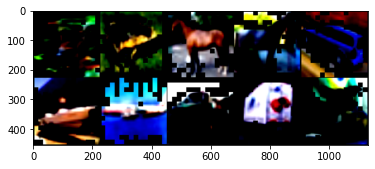

In [32]:
plt.imshow(grid_occ)